In [1]:
import sys
print(sys.version)

3.7.0 (default, Jun 28 2018, 07:39:16) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

#from celerite import plot_setup
#plot_setup.setup()

In [3]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Learning Celerite

number of points: 125


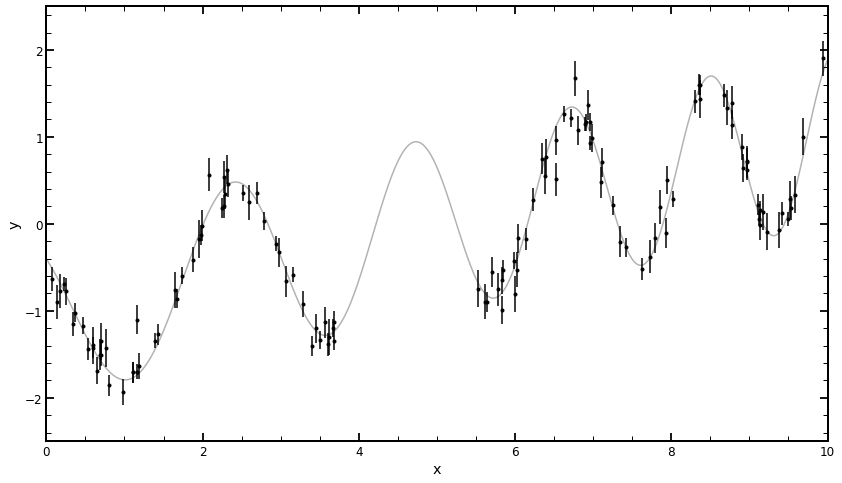

In [82]:
# lets simulate the data
# this is taken from the tutorial
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
print('number of points: '+str(len(t)))
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

plt.figure(figsize=(14,8))
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

In [61]:
import celerite
from celerite import terms
import autograd.numpy as np

# build the CAR(1,0) model
# A non-periodic component
a = 10.0
c = 3.0
bounds = dict(log_a=(-15, 15), log_c=(-15, 15))
kernel = terms.RealTerm(log_a=np.log(a), log_c=np.log(c),
                       bounds=bounds)

In [62]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -162.48695285952982


In [63]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

parameter_dict:
OrderedDict([('kernel:log_a', 2.302585092994046), ('kernel:log_c', 1.0986122886681098)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[2.30258509 1.09861229]

parameter_bounds:
[(-15, 15), (-15, 15)]



In [64]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: 15.582431110361654
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.13686838e-05, 5.68434189e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 14
   status: 0
  success: True
        x: array([ 0.13080496, -1.12058275])


In [65]:
gp.get_parameter_dict()

OrderedDict([('kernel:log_a', 0.13080495707536954),
             ('kernel:log_c', -1.1205827510679545)])

In [66]:
x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

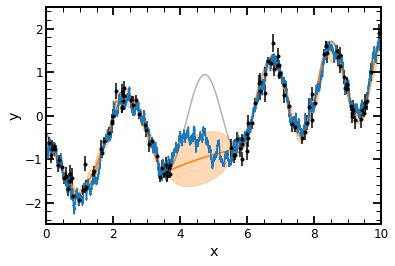

In [68]:
# this is realization of one sample given the PSD that was deduced
# this takes some time, as mentioned in the turotial
one_sample=gp.sample_conditional(y,x,size=1)

color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.plot(x,one_sample[0])
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

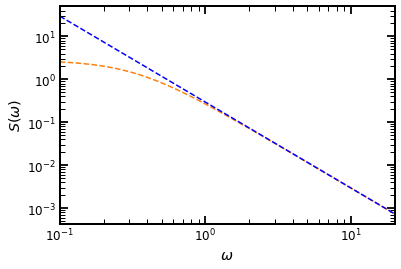

In [69]:
# PSD, overplotted with exact power-law
omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

#plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)
    
plt.plot(omega, k.get_psd(omega[-1])*(omega**-2/omega[-1]**-2), "--", color='blue')
plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [76]:
one_sample_unconditonal=gp.sample(size=10)

In [73]:
print(len(one_sample[0]))
print(len(one_sample_unconditonal[0]))
print(len(t))

5000
125
125


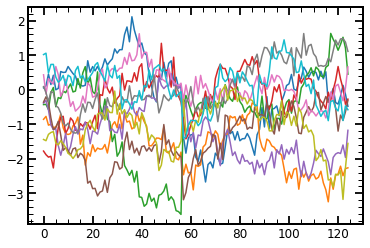

In [80]:
for i in range(10):
    plt.plot(one_sample_unconditonal[i],marker='',ls='-')

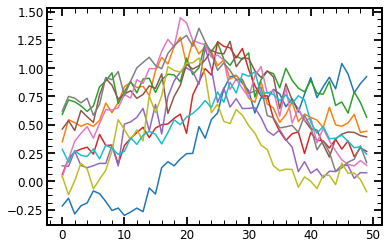

In [98]:
# Simuate the data
for i in range(10):
    #np.random.seed(42+i)
    x = np.sort(np.random.uniform(-5, 5, 50))
    yerr = np.random.uniform(0.05, 0.1, len(x))
    # not sure what these offdiagonal element do and where did they come from
    K = 0.1*np.exp(-0.5*(x[:, None] - x[None, :])**2/10.5)
    K[np.diag_indices(len(x))] += yerr**2

    y = np.random.multivariate_normal(kernel.get_value(x),K)
    plt.plot(y)